<a href="https://colab.research.google.com/github/nicoataiza/CS7318/blob/main/Assignment_3_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install yahoofinancials
!pip install pmdarima
!pip install arch

In [90]:
%matplotlib inline
from yahoofinancials import YahooFinancials
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import pmdarima as pm
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import torch
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from arch.univariate import EGARCH
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.models import load_model
from itertools import product

In [67]:
tickers = ['^GSPC','^DJI','^N100','^N225']
spPrices =  YahooFinancials(tickers).get_historical_price_data('2018-01-01', '2023-11-08', 'daily')

# Loading in Data

In [68]:
def load_to_df(stock_name):
  df = pd.DataFrame(spPrices[stock_name]['prices'])
  df['date_time'] = pd.to_datetime(df['date'],unit='s')
  df.drop(['date','formatted_date'],inplace=True,axis=1)
  df.dropna(inplace=True)
  df.set_index('date_time',inplace=True)
  # Print the resulting DataFrame
  return df

# Data Transformations

Since investors are more interested in price returns (i.e., price
variation) rather than price itself (see, e.g., Hajizadeh et al., 2012; Hu
et al., 2020; Khaldi et al., 2019; Kristjanpoller & Minutolo, 2018; Peng
et al., 2018; Seo & Kim, 2020), and because return data is usually
stationary and hence, appropriate to use in time series models, we
decided to do our experiments with this variable. Therefore, the price
returns were calculated by using the following equation:

𝑟𝑡 = log (
𝑃𝑡
)
− log (
𝑃𝑡−1)

In [69]:
def get_price_returns(df):
  df2 = df
  df2['log-price'] = np.log(df['close'])
  df2.diff()['log-price']
  df['return'] = df2.diff()['log-price']
  df.dropna(inplace=True)

Taken from [this research paper](https://www.sciencedirect.com/science/article/pii/S266682702300018X?ref=pdf_download&fr=RR-2&rr=8284bf74ca261f5c):

To evaluate our models’ performances, we need to compare predicted values of volatility with its actual values, however, volatility
is an unobservable variable, and it is not measurable. As standard
deviation indicates how much a cryptocurrency has varied during a
certain period, we used this feature as a proxy for volatility. Therefore,
historical volatility at time t was calculated as standard deviations of
the returns’ values using Eq.

$HV_t=\sqrt{\frac{1}{T}\sum_{i=t-T}^{t}(r_{i}-\hat{r_t})^2}$

where 𝑟𝑖
is the price return of cryptocurrency on day i, and 𝑟𝑡
is the
average return of cryptocurrency during past 𝑇 trading days. 𝑇 = 30
(approximately one month of transactions) will be considered in this
study

In [70]:
def get_historical_volatility(df,T=30):
  HV = []
  for i in range(0,df.shape[0]-T):
    period = df.iloc[i:i+T,:]
    period_mean = period['return'].mean()
    HV.append((sum((period['return'] - period_mean) ** 2) * (1/2))**0.5)
  df['HVt'] = [np.nan] * T + HV
  df.dropna(inplace=True)

In [71]:
def adf_test(timeseries):
  # taken from: https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/
  # Test for stationary
  #Determing rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()
  #Plot rolling statistics:
  plt.plot (timeseries, color='blue', label='Original')
  plt.plot (rolmean, color='red', label='Rolling Mean' )
  plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt. legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)

  print("Results of Dickey-Fuller Test:")
  dftest = adfuller(timeseries, autolag="AIC")
  dfoutput = pd.Series(
      dftest[0:4],
      index=[
          "Test Statistic",
          "p-value",
          "#Lags Used",
          "Number of Observations Used",
      ],
  )
  for key, value in dftest[4].items():
      dfoutput["Critical Value (%s)" % key] = value
  print(dfoutput)
  return dfoutput

# Get Descriptive Statistics

In [ ]:
ini = {'Index':[],
    'Observations':[],
       'Mean':[],
       'SD':[],
       'ADF-stat':[],
       'ADF-p value':[]}


In [ ]:
ds = pd.DataFrame(ini)

INDEX: ^GSPC


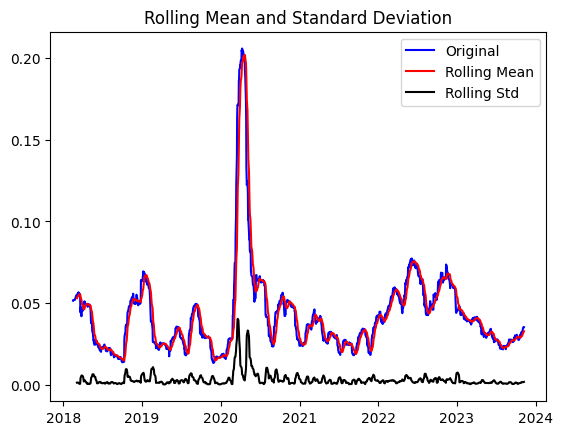

Results of Dickey-Fuller Test:
Test Statistic                   -5.055091
p-value                           0.000017
#Lags Used                       12.000000
Number of Observations Used    1429.000000
Critical Value (1%)              -3.434934
Critical Value (5%)              -2.863565
Critical Value (10%)             -2.567848
dtype: float64
INDEX: ^DJI


<ipython-input-34-ba4bca9e5e17>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(to_add,ignore_index = True)


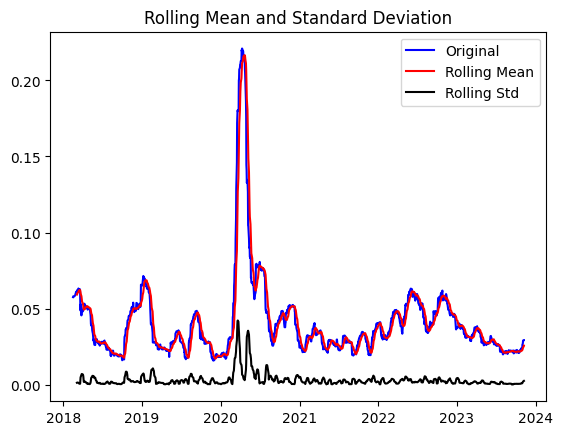

Results of Dickey-Fuller Test:
Test Statistic                   -4.482571
p-value                           0.000211
#Lags Used                       22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64
INDEX: ^N100


<ipython-input-34-ba4bca9e5e17>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(to_add,ignore_index = True)


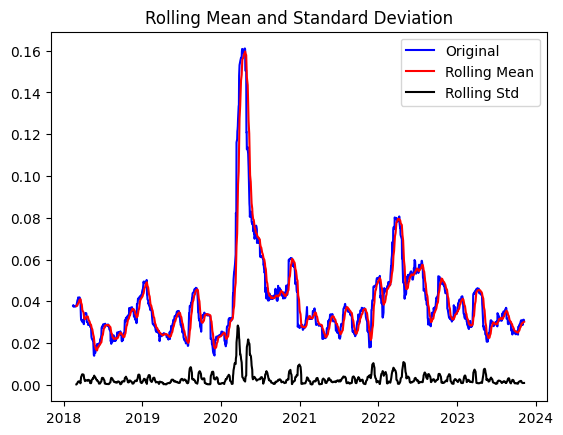

Results of Dickey-Fuller Test:
Test Statistic                   -5.043132
p-value                           0.000018
#Lags Used                       10.000000
Number of Observations Used    1459.000000
Critical Value (1%)              -3.434840
Critical Value (5%)              -2.863523
Critical Value (10%)             -2.567826
dtype: float64
INDEX: ^N225


<ipython-input-34-ba4bca9e5e17>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(to_add,ignore_index = True)


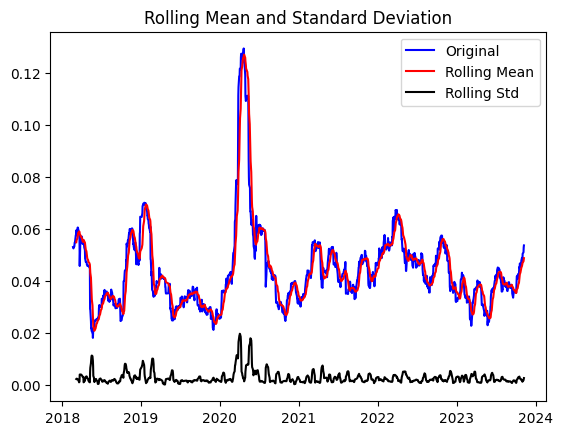

Results of Dickey-Fuller Test:
Test Statistic                   -4.757925
p-value                           0.000065
#Lags Used                       12.000000
Number of Observations Used    1384.000000
Critical Value (1%)              -3.435084
Critical Value (5%)              -2.863631
Critical Value (10%)             -2.567883
dtype: float64


<ipython-input-34-ba4bca9e5e17>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds = ds.append(to_add,ignore_index = True)


In [ ]:
for stock in tickers:
  print('INDEX:',stock)
  df = load_to_df(stock)
  get_price_returns(df)
  get_historical_volatility(df)
  res = adf_test(df['HVt'])
  cc = df['HVt'].describe()
  to_add = {'Index':stock,
      'Observations':cc['count'],
       'Mean':cc['mean'],
       'SD':cc['std'],
       'ADF-stat':res['Test Statistic'],
       'ADF-p value':res['p-value']}
  ds = ds.append(to_add,ignore_index = True)
ds.to_csv(r'/content/drive/MyDrive/Uni of Adelaide/CS7318/Assignment 3/des_stats.csv')

# GARCH and GARCH-LIKE



In [72]:
model = ['Garch','EGARCH']
d = ['normal','t','ged']
out = {}
for i in product(model,d):
  out[str(i)] = 0
print(out)

{"('Garch', 'normal')": 0, "('Garch', 't')": 0, "('Garch', 'ged')": 0, "('EGARCH', 'normal')": 0, "('EGARCH', 't')": 0, "('EGARCH', 'ged')": 0}


In [74]:
def tvt_s(df):
  # 70-15-15 split
  _2023_train_end = '2022-02-07'
  _2023_validation_end = '2023-01-01'
  _2018ow = df.index.to_series().between('2018-01-01',_2023_train_end)
  _2023_va = df.index.to_series().between(_2023_train_end,_2023_validation_end)
  df_train = df[_2018ow]
  df_val = df[_2023_va]
  df_t = df.loc[_2023_validation_end:]
  return df_train, df_val, df_t

In [85]:
g_mse = pd.DataFrame()
g_mape = pd.DataFrame()

for stock in tickers:
  print('INDEX:',stock)
  df = load_to_df(stock)
  get_price_returns(df)
  get_historical_volatility(df)
  _train, _val, _test = tvt_s(df)
  out_mse = {'Index':stock}
  out_mape = {'Index':stock}
  for i in product(model,d):
    print('model:', i)
    print('-----------------------------')
    model_garch = arch_model(_train['HVt'], vol=i[0], p=1, q=1,dist=i[1])
    fit_garch = model_garch.fit()
    forecast_volatility = fit_garch.forecast(horizon=_test.shape[0],method='simulation')
    mape = mean_absolute_percentage_error(_test['HVt'], forecast_volatility.mean.iloc[-1].values)
    mse = mean_squared_error(_test['HVt'],forecast_volatility.mean.iloc[-1].values)
    print("MSE:", mse)
    print("MAPE:", mape)
    out_mse[i] = mse
    out_mape[i] = mape
  g_mse = g_mse.append(out_mse,ignore_index = True)
  g_mape = g_mape.append(out_mape,ignore_index = True)
g_mse.to_csv(r'/content/drive/MyDrive/Uni of Adelaide/CS7318/Assignment 3/g_mse.csv')
g_mape.to_csv(r'/content/drive/MyDrive/Uni of Adelaide/CS7318/Assignment 3/g_mape.csv')

INDEX: ^GSPC
model: ('Garch', 'normal')
-----------------------------
Iteration:      1,   Func. Count:      6,   Neg. LLF: 17724776763.3105
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.581663992963867e+16
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3.254744904924197e+21
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3030268785.7007694
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.4548980835642253e+17
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2737044859361477.5
Iteration:      7,   Func. Count:     89,   Neg. LLF: -2925.4047675337815
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2925.404785762071
            Iterations: 11
            Function evaluations: 89
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


MSE: 6.007230634029773e-05
MAPE: 0.17263684878592928
model: ('Garch', 't')
-----------------------------
Iteration:      1,   Func. Count:      7,   Neg. LLF: 271950.8860387548
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4878.546762152259
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4625.365972717623
Iteration:      4,   Func. Count:     38,   Neg. LLF: 13709.323981729092
Iteration:      5,   Func. Count:     45,   Neg. LLF: 7016.439471055317
Iteration:      6,   Func. Count:     52,   Neg. LLF: 225828.40756238287
Iteration:      7,   Func. Count:     65,   Neg. LLF: 1487.7014274268768
Iteration:      8,   Func. Count:     73,   Neg. LLF: 382286.3352931619
Iteration:      9,   Func. Count:     89,   Neg. LLF: 383128.70843441214
Iteration:     10,   Func. Count:    105,   Neg. LLF: 404.1540596680088
Iteration:     11,   Func. Count:    111,   Neg. LLF: 210049.96242396615
Iteration:     12,   Func. Count:    118,   Neg. LLF: 469516.25007218856
Iteration:     13,   Func

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     16,   Func. Count:    154,   Neg. LLF: 2221411.242488851
Iteration:     17,   Func. Count:    170,   Neg. LLF: 614540.1095097836
Iteration:     18,   Func. Count:    182,   Neg. LLF: 2207948.1535933213
Iteration:     19,   Func. Count:    195,   Neg. LLF: 30057.420212650344
Optimization terminated successfully    (Exit mode 0)
            Current function value: 30057.4202121008
            Iterations: 23
            Function evaluations: 195
            Gradient evaluations: 19
MSE: 77.43082450177167
MAPE: 281.16784083901825
model: ('Garch', 'ged')
-----------------------------
Iteration:      1,   Func. Count:      7,   Neg. LLF: inf
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1.6044833898393204e+259
Iteration:      3,   Func. Count:     37,   Neg. LLF: 7382369656218.897
Iteration:      4,   Func. Count:     52,   Neg. LLF: inf
Iteration:      5,   Func. Count:     68,   Neg. LLF: 1.3791129407315407e+280
Iteration:      6,   Func. Count:     81,   Neg. LLF: 5

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


MSE: 6.515164988806287e-05
MAPE: 0.17529240084772943
model: ('EGARCH', 'normal')
-----------------------------
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3739829950613747e+18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 208861118842215.3
Iteration:      3,   Func. Count:     30,   Neg. LLF: 82969471275.08057
Iteration:      4,   Func. Count:     38,   Neg. LLF: -2123.5691666764224
Iteration:      5,   Func. Count:     45,   Neg. LLF: -3100.716162398305
Iteration:      6,   Func. Count:     50,   Neg. LLF: 456848199.3425491
Iteration:      7,   Func. Count:     57,   Neg. LLF: 3254.3399868677725
Iteration:      8,   Func. Count:     64,   Neg. LLF: -2369.2015029236354
Iteration:      9,   Func. Count:     72,   Neg. LLF: -3161.0407669120277
Iteration:     10,   Func. Count:     77,   Neg. LLF: -3196.591250759333
Iteration:     11,   Func. Count:     82,   Neg. LLF: -3219.2856227788197
Iteration:     12,   Func. Count:     87,   Neg. LLF: -3227.3104909663643
Iterati

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


            Function evaluations: 196
            Gradient evaluations: 31
MSE: 6.345324004641005e-05
MAPE: 0.17421104540740204
model: ('EGARCH', 't')
-----------------------------


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 73302.39209023237
Iteration:      2,   Func. Count:     23,   Neg. LLF: 48958.04645088593
Iteration:      3,   Func. Count:     31,   Neg. LLF: 89199.62929617663
Iteration:      4,   Func. Count:     40,   Neg. LLF: 4796.9303379819885
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4665.997773628969
Iteration:      6,   Func. Count:     52,   Neg. LLF: 4259.164219594425
Iteration:      7,   Func. Count:     58,   Neg. LLF: 4123.2301259628275
Iteration:      8,   Func. Count:     64,   Neg. LLF: 3390.748137792896
Iteration:      9,   Func. Count:     70,   Neg. LLF: 2166990.156966979
Iteration:     10,   Func. Count:     78,   Neg. LLF: 259386.14808399027
Iteration:     11,   Func. Count:     85,   Neg. LLF: 37571.71950580889
Iteration:     12,   Func. Count:     93,   Neg. LLF: 23606.637758338107
Iteration:     13,   Func. Count:    101,   Neg. LLF: 21922.204227953825
Iteration:     14,   Func. Count:    109,   Neg. LLF: 18340

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:      2,   Func. Count:     23,   Neg. LLF: inf
Iteration:      3,   Func. Count:     35,   Neg. LLF: inf
Iteration:      4,   Func. Count:     44,   Neg. LLF: inf
Iteration:      5,   Func. Count:     53,   Neg. LLF: 184161.6305566643
Iteration:      6,   Func. Count:     60,   Neg. LLF: 156.1594616898301
Iteration:      7,   Func. Count:     69,   Neg. LLF: 3.319754390899176e+200
Iteration:      8,   Func. Count:     77,   Neg. LLF: -3181.012829854611
Iteration:      9,   Func. Count:     83,   Neg. LLF: -3197.2896039691404
Iteration:     10,   Func. Count:     89,   Neg. LLF: -3164.601918446623
Iteration:     11,   Func. Count:     96,   Neg. LLF: -3231.65121017371
Iteration:     12,   Func. Count:    102,   Neg. LLF: -3249.6490426466034
Iteration:     13,   Func. Count:    108,   Neg. LLF: -3264.532596212077
Iteration:     14,   Func. Count:    114,   Neg. LLF: -3267.565303517617
Iteration:     15,   Func. Count:    120,   Neg. LLF: -3280.8206210692592
Iteration:     16, 

<ipython-input-85-e43ce851c5c6>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  g_mse = g_mse.append(out_mse,ignore_index = True)
<ipython-input-85-e43ce851c5c6>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  g_mape = g_mape.append(out_mape,ignore_index = True)


model: ('Garch', 'normal')
-----------------------------
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5801024692511635e+21
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2.8296905456370694e+27
Iteration:      3,   Func. Count:     36,   Neg. LLF: 15155891178.952168
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3217754.1588612814
Iteration:      5,   Func. Count:     64,   Neg. LLF: 11576830351.15304
Iteration:      6,   Func. Count:     78,   Neg. LLF: 3.485388821396362e+19
Iteration:      7,   Func. Count:     93,   Neg. LLF: 4387555406.773368
Iteration:      8,   Func. Count:    106,   Neg. LLF: 6.340261044744565e+19
Iteration:      9,   Func. Count:    118,   Neg. LLF: -2928.948473144076
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2928.9484939056438
            Iterations: 13
            Function evaluations: 118
            Gradient evaluations: 9
MSE: 3.528638753069259e-05
MAPE: 0.19535473210762697
model: ('G

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     38,   Neg. LLF: 107787.1032727379
Iteration:      5,   Func. Count:     45,   Neg. LLF: 3676.6882737917203
Iteration:      6,   Func. Count:     51,   Neg. LLF: 4204.382377686713
Iteration:      7,   Func. Count:     58,   Neg. LLF: 3342.597220152234
Iteration:      8,   Func. Count:     65,   Neg. LLF: 1247.418517220181
Iteration:      9,   Func. Count:     71,   Neg. LLF: 10875.724999786957
Iteration:     10,   Func. Count:     81,   Neg. LLF: 221779.19625348685
Iteration:     11,   Func. Count:     90,   Neg. LLF: 1426.0431802751718
Iteration:     12,   Func. Count:     97,   Neg. LLF: 170770.36128489452
Iteration:     13,   Func. Count:    104,   Neg. LLF: 12011.493333323702
Iteration:     14,   Func. Count:    111,   Neg. LLF: 238034.8363616392
Iteration:     15,   Func. Count:    126,   Neg. LLF: 1684431.3876407165
Iteration:     16,   Func. Count:    138,   Neg. LLF: 1077682.0898748378
Iteration:     17,   Func. Count:    146,   Neg. LLF: 12

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by eith

Iteration:     19,   Func. Count:    124,   Neg. LLF: -3273.1578989342506
Iteration:     20,   Func. Count:    129,   Neg. LLF: -3273.6492047496454
Iteration:     21,   Func. Count:    134,   Neg. LLF: -3274.3395511506706
Iteration:     22,   Func. Count:    139,   Neg. LLF: -3274.934540885837
Iteration:     23,   Func. Count:    144,   Neg. LLF: -3275.1801768684104
Iteration:     24,   Func. Count:    149,   Neg. LLF: -3275.226992789717
Iteration:     25,   Func. Count:    154,   Neg. LLF: -3275.2326848713546
Iteration:     26,   Func. Count:    159,   Neg. LLF: -3275.2332003255074
Iteration:     27,   Func. Count:    164,   Neg. LLF: -3275.233239115886
Iteration:     28,   Func. Count:    169,   Neg. LLF: -3275.2332469756802
Iteration:     29,   Func. Count:    174,   Neg. LLF: -3275.2332476181696
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3275.2332476181696
            Iterations: 29
            Function evaluations: 174
            Gr

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:2774: RuntimeWarning: overflow encountered in exp
  paths[loc, :, :] = np.exp(_lnsigma2[:, m:])
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001137. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling

Iteration:      1,   Func. Count:      7,   Neg. LLF: inf
Iteration:      2,   Func. Count:     23,   Neg. LLF: inf
Iteration:      3,   Func. Count:     31,   Neg. LLF: inf
Iteration:      4,   Func. Count:     41,   Neg. LLF: inf
Iteration:      5,   Func. Count:     52,   Neg. LLF: -839.1933432820344
Iteration:      6,   Func. Count:     60,   Neg. LLF: 5.6019382246396255e+143
Iteration:      7,   Func. Count:     68,   Neg. LLF: 6.219739346969014e+150
Iteration:      8,   Func. Count:     76,   Neg. LLF: 8.379055170520947e+78
Iteration:      9,   Func. Count:     84,   Neg. LLF: 1035897.1123191842
Iteration:     10,   Func. Count:     91,   Neg. LLF: 1.7806631182452533e+39
Iteration:     11,   Func. Count:     99,   Neg. LLF: 725829707.805356
Iteration:     12,   Func. Count:    106,   Neg. LLF: 934749.4268965091
Iteration:     13,   Func. Count:    114,   Neg. LLF: -1848.8209295712938
Iteration:     14,   Func. Count:    122,   Neg. LLF: -2827.639851628146
Iteration:     15,   Fun

<ipython-input-85-e43ce851c5c6>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  g_mse = g_mse.append(out_mse,ignore_index = True)
<ipython-input-85-e43ce851c5c6>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  g_mape = g_mape.append(out_mape,ignore_index = True)


model: ('Garch', 'normal')
-----------------------------
Iteration:      1,   Func. Count:      6,   Neg. LLF: 108409485700.71121
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2460366041.5316534
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8.381307078036058e+18
Iteration:      4,   Func. Count:     47,   Neg. LLF: 28361951459.19057
Iteration:      5,   Func. Count:     60,   Neg. LLF: 4880091980.930652
Iteration:      6,   Func. Count:     72,   Neg. LLF: 2.3261272980248992e+20
Iteration:      7,   Func. Count:     87,   Neg. LLF: 4.915883681111163e+21
Iteration:      8,   Func. Count:    100,   Neg. LLF: -3277.5082874891514
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3277.5083059054914
            Iterations: 12
            Function evaluations: 100
            Gradient evaluations: 8
MSE: 4.2625248307646654e-05
MAPE: 0.15123463742031362
model: ('Garch', 't')
-----------------------------
Iteration:      1,   Func. Count:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


MSE: 38.482947012684676
MAPE: 199.58127545820622
model: ('Garch', 'ged')
-----------------------------
Iteration:      1,   Func. Count:      7,   Neg. LLF: inf
Iteration:      2,   Func. Count:     23,   Neg. LLF: inf
Iteration:      3,   Func. Count:     38,   Neg. LLF: inf
Iteration:      4,   Func. Count:     54,   Neg. LLF: inf
Iteration:      5,   Func. Count:     69,   Neg. LLF: 1503097560.7975368
Iteration:      6,   Func. Count:     84,   Neg. LLF: 20252.176114576658
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 20252.174677446295
            Iterations: 9
            Function evaluations: 84
            Gradient evaluations: 6
MSE: 18.828883246969234
MAPE: 139.5924523954933
model: ('EGARCH', 'normal')
-----------------------------
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.2843478088852767e+19
Iteration:      2,   Func. Count:     20,   Neg. LLF: 351685540265039.1
Iteration:      3,   Func. Count:     30,   Neg. LLF: 105

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect c

MSE: 5.4763145270839185e-05
MAPE: 0.1487933045091197
model: ('EGARCH', 't')
-----------------------------
Iteration:      1,   Func. Count:      7,   Neg. LLF: 84235.29338052747
Iteration:      2,   Func. Count:     23,   Neg. LLF: 9523.926372045793
Iteration:      3,   Func. Count:     32,   Neg. LLF: 9490.051174456927
Iteration:      4,   Func. Count:     39,   Neg. LLF: 9483.533423445244
Iteration:      5,   Func. Count:     46,   Neg. LLF: 9481.554793258218
Iteration:      6,   Func. Count:     53,   Neg. LLF: 9494.35107560163
Iteration:      7,   Func. Count:     60,   Neg. LLF: 9463.85983103681
Iteration:      8,   Func. Count:     67,   Neg. LLF: 9457.475001660256
Iteration:      9,   Func. Count:     74,   Neg. LLF: 9451.450628973755
Iteration:     10,   Func. Count:     81,   Neg. LLF: 7345.589816099042
Iteration:     11,   Func. Count:     87,   Neg. LLF: 7232.694085600813
Iteration:     12,   Func. Count:     93,   Neg. LLF: 7202.971312622724
Iteration:     13,   Func. Count

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     70,   Func. Count:    476,   Neg. LLF: -3542.7206065528944
Iteration:     71,   Func. Count:    482,   Neg. LLF: -3542.7436101720523
Iteration:     72,   Func. Count:    488,   Neg. LLF: -3542.75179028692
Iteration:     73,   Func. Count:    495,   Neg. LLF: -3542.7563596570853
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3542.7596565689228
            Iterations: 73
            Function evaluations: 505
            Gradient evaluations: 73
MSE: 4.805986506249179e-05
MAPE: 0.14429523542568284
model: ('EGARCH', 'ged')
-----------------------------
Iteration:      1,   Func. Count:      7,   Neg. LLF: inf
Iteration:      2,   Func. Count:     23,   Neg. LLF: inf
Iteration:      3,   Func. Count:     32,   Neg. LLF: 68167495.20940891
Iteration:      4,   Func. Count:     42,   Neg. LLF: 6.144231128874533e+251
Iteration:      5,   Func. Count:     50,   Neg. LLF: 12397500.378307922
Iteration:      6,   Func. Count:     57,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


Iteration:     43,   Func. Count:    302,   Neg. LLF: -3612.366670454882
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3612.3666839368207
            Iterations: 43
            Function evaluations: 312
            Gradient evaluations: 43
MSE: 5.488678058591784e-05
MAPE: 0.1489462170750989
INDEX: ^N225


<ipython-input-85-e43ce851c5c6>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  g_mse = g_mse.append(out_mse,ignore_index = True)
<ipython-input-85-e43ce851c5c6>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  g_mape = g_mape.append(out_mape,ignore_index = True)


model: ('Garch', 'normal')
-----------------------------
Iteration:      1,   Func. Count:      6,   Neg. LLF: 75893178713.62735
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4.959668195562164e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2.8091716419698106e+19
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1015309691206.2003
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3.161539594909297e+20
Iteration:      6,   Func. Count:     77,   Neg. LLF: 186267859822.59952
Iteration:      7,   Func. Count:     87,   Neg. LLF: 1147935599915.4365
Iteration:      8,   Func. Count:    102,   Neg. LLF: 7778364989.898481
Iteration:      9,   Func. Count:    114,   Neg. LLF: 1.3810639256810796e+20
Iteration:     10,   Func. Count:    126,   Neg. LLF: 1.2263464339736924e+19
Iteration:     11,   Func. Count:    141,   Neg. LLF: 4862731362149765.0
Iteration:     12,   Func. Count:    156,   Neg. LLF: 569933756034.5779
Iteration:     13,   Func. Count:    168,   Neg. LLF

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003233. Parameter
estimation work better when this value is between 1 and 1000. The recomme

Iteration:     21,   Func. Count:    192,   Neg. LLF: 4135.023589741075
Iteration:     22,   Func. Count:    198,   Neg. LLF: 166081.1708144906
Iteration:     23,   Func. Count:    205,   Neg. LLF: 2911.600568449745
Iteration:     24,   Func. Count:    211,   Neg. LLF: 19690.518870779233
Iteration:     25,   Func. Count:    219,   Neg. LLF: 2742.256831347043
Iteration:     26,   Func. Count:    227,   Neg. LLF: 810.6003382679585
Iteration:     27,   Func. Count:    235,   Neg. LLF: 493596.568386049
Iteration:     28,   Func. Count:    251,   Neg. LLF: 3436.378639480727
Iteration:     29,   Func. Count:    257,   Neg. LLF: 242869.75690055927
Iteration:     30,   Func. Count:    264,   Neg. LLF: 11709.328163781538
Iteration:     31,   Func. Count:    271,   Neg. LLF: 1651.2777826587517
Iteration:     32,   Func. Count:    276,   Neg. LLF: 1651.2777826659553
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1651.2777826587517
            Iterations:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by 

MSE: 0.005047688655705967
MAPE: 1.9574930987539674
model: ('EGARCH', 'normal')
-----------------------------
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.8939134577726838e+18
Iteration:      2,   Func. Count:     20,   Neg. LLF: 357862698751147.9
Iteration:      3,   Func. Count:     30,   Neg. LLF: 135775750960.52896
Iteration:      4,   Func. Count:     38,   Neg. LLF: -942.469081383927
Iteration:      5,   Func. Count:     46,   Neg. LLF: 150202.54277874908
Iteration:      6,   Func. Count:     53,   Neg. LLF: -3249.5534613857626
Iteration:      7,   Func. Count:     58,   Neg. LLF: -3255.8983478970094
Iteration:      8,   Func. Count:     63,   Neg. LLF: -3269.968454490988
Iteration:      9,   Func. Count:     68,   Neg. LLF: -2855.4231305731
Iteration:     10,   Func. Count:     76,   Neg. LLF: -3281.28516779193
Iteration:     11,   Func. Count:     81,   Neg. LLF: -3288.3733625838195
Iteration:     12,   Func. Count:     86,   Neg. LLF: -3295.4266262980354
Iteration:  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     23,   Func. Count:    197,   Neg. LLF: 712.3248664322387
Iteration:     24,   Func. Count:    205,   Neg. LLF: 570.9596552343857
Iteration:     25,   Func. Count:    211,   Neg. LLF: 568.0428852763554
Iteration:     26,   Func. Count:    217,   Neg. LLF: 564.9829610323332
Iteration:     27,   Func. Count:    223,   Neg. LLF: 555.1918821261024
Iteration:     28,   Func. Count:    229,   Neg. LLF: 543.6969527360825
Iteration:     29,   Func. Count:    235,   Neg. LLF: 537.7231992004388
Iteration:     30,   Func. Count:    241,   Neg. LLF: 528.7916848759473
Iteration:     31,   Func. Count:    247,   Neg. LLF: 523.6800320859554
Iteration:     32,   Func. Count:    253,   Neg. LLF: 522.2504482376022
Iteration:     33,   Func. Count:    260,   Neg. LLF: 520.9753514673484
Iteration:     34,   Func. Count:    266,   Neg. LLF: 520.7364867272272
Iteration:     35,   Func. Count:    272,   Neg. LLF: 520.7103117232543
Iteration:     36,   Func. Count:    278,   Neg. LLF: 520.655807

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu
<ipython-input-85-e43ce851c5c6>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  g_mse = g_mse.append(out_mse,ignore_index = True)
<ipython-input-85-e43ce851c5c6>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

# Deep Learning

In [91]:
import keras

In [109]:
# my hyperparams
models = ['RNN','LSTM']
units = [10,50,100]
out = {}
for i in product(models,units):
  out[str(i)] = 0
print(out)

{"('RNN', 10)": 0, "('RNN', 50)": 0, "('RNN', 100)": 0, "('LSTM', 10)": 0, "('LSTM', 50)": 0, "('LSTM', 100)": 0}


In [104]:
def model_gen(model_type, units):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(units=units, input_shape=(1, 1),return_sequences=True))
    elif model_type == 'RNN':
        model.add(SimpleRNN(units=units, input_shape=(1, 1),return_sequences=True))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=['mae','mean_absolute_percentage_error'])
    return model

def create_sequences(data):
    xs, ys = [], []
    for i in range(len(data)-1):
        x = data['HVt'][i]
        # 'Residual' at the next time step
        # NOTE: The way the data is cleaned -> HVt includes the last 30 days
        y = data['HVt'][i+1]
        xs.append([x])
        ys.append(y)
    return np.array(xs), np.array(ys)

def dl_tts(X,y):
  ts = int(len(X) * 0.70)
  vs = int(len(X)* 0.15 // 1)
  X_train, X_temp, y_train, y_temp = X[:ts], X[ts:], y[:ts], y[ts:]
  X_val, X_test, y_val, y_test = X_temp[:vs], X_temp[vs:], y_temp[:vs], y_temp[vs:]
  # print(X_train)
  return X_train, y_train, X_val, y_val, X_test, y_test

INDEX: ^GSPC
----------------------
Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0291 - mean_absolute_percentage_error: 81.1298
Epoch 1: val_loss improved from inf to 0.00037, saving model to RNN_10
32/32 [==============================] - 8s 115ms/step - loss: 0.0017 - mae: 0.0291 - mean_absolute_percentage_error: 81.8632 - val_loss: 3.6674e-04 - val_mae: 0.0160 - val_mean_absolute_percentage_error: 24.7982
Epoch 2/10
23/32 [====================>.........] - ETA: 0s - loss: 0.0012 - mae: 0.0201 - mean_absolute_percentage_error: 53.0707
Epoch 2: val_loss did not improve from 0.00037
32/32 [==============================] - 0s 4ms/step - loss: 0.0011 - mae: 0.0196 - mean_absolute_percentage_error: 54.7136 - val_loss: 6.1714e-04 - val_mae: 0.0225 - val_mean_absolute_percentage_error: 35.8989
Epoch 3/10
24/32 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0199 - mean_absolute_percentage_error: 55.5502
Epoch 3: val_loss did not imp

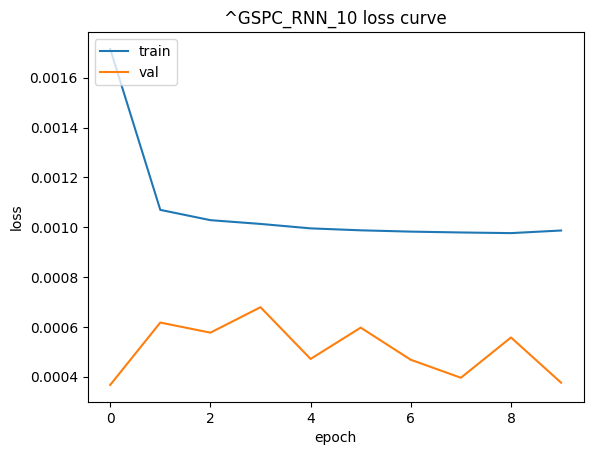


7/7 [==============================] - 0s 2ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - mae: 0.0222 - mean_absolute_percentage_error: 59.0465 
Epoch 1: val_loss improved from inf to 0.00032, saving model to RNN_50
32/32 [==============================] - 4s 79ms/step - loss: 0.0011 - mae: 0.0209 - mean_absolute_percentage_error: 57.7506 - val_loss: 3.1666e-04 - val_mae: 0.0157 - val_mean_absolute_percentage_error: 24.7972
Epoch 2/10
27/32 [========================>.....] - ETA: 0s - loss: 9.8746e-04 - mae: 0.0183 - mean_absolute_percentage_error: 49.9612
Epoch 2: val_loss improved from 0.00032 to 0.00031, saving model to RNN_50
32/32 [==============================] - 2s 72ms/step - loss: 9.8312e-04 - mae: 0.0183 - mean_absolute_percentage_error: 50.2485 - val_loss: 3.1178e-04 - val_mae: 0.0154 - val_mean_absolute_percentage_error: 24.1283
Epoch 3/10
28/32 [=========================>....] - ETA: 0s - loss: 9.8925e-04 - mae: 0.0186 - mean_absolute_percentage_error: 51.8565
Epoch 3: val_loss did no

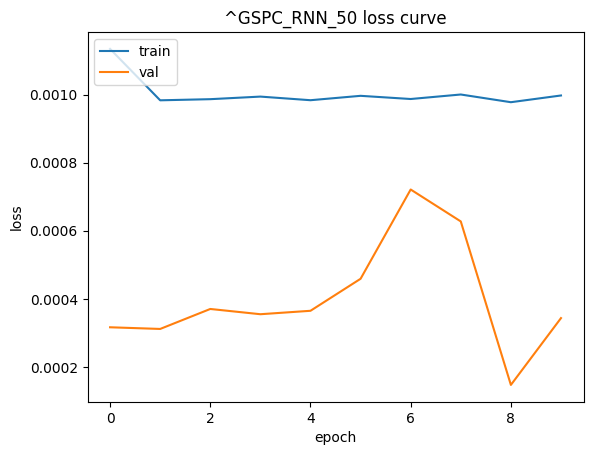


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - mae: 0.0266 - mean_absolute_percentage_error: 75.3953  
Epoch 1: val_loss improved from inf to 0.00034, saving model to RNN_100
32/32 [==============================] - 3s 59ms/step - loss: 0.0013 - mae: 0.0239 - mean_absolute_percentage_error: 67.2285 - val_loss: 3.3867e-04 - val_mae: 0.0157 - val_mean_absolute_percentage_error: 24.6023
Epoch 2/10
20/32 [=================>............] - ETA: 0s - loss: 8.4957e-04 - mae: 0.0178 - mean_absolute_percentage_error: 50.4580
Epoch 2: val_loss did not improve from 0.00034
32/32 [==============================] - 0s 4ms/step - loss: 9.9557e-04 - mae: 0.0189 - mean_absolute_percentage_error: 53.2400 - val_loss: 3.4529e-04 - val_mae: 0.0162 - val_mean_absolute_percentage_error: 25.5205
Epoch 3/10
21/32 [==================>...........] - ETA: 0s - loss: 0.0011 - mae: 0.0192 - mean_absolute_percentage_error: 53.8031    
Epoch 3: val_loss did not improve from 0.00034
32/3

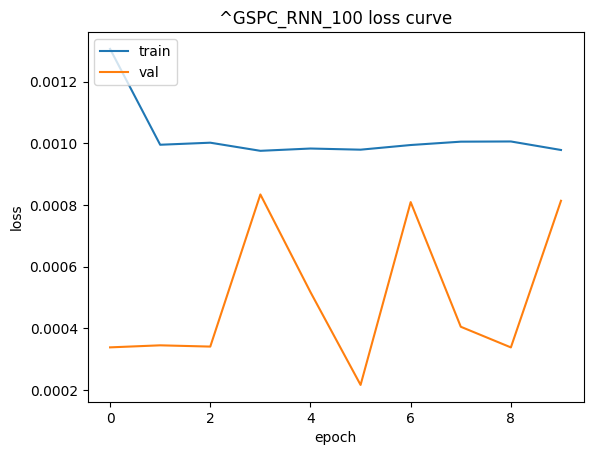


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
21/32 [==================>...........] - ETA: 0s - loss: 0.0020 - mae: 0.0291 - mean_absolute_percentage_error: 61.2604
Epoch 1: val_loss improved from inf to 0.00039, saving model to LSTM_10
32/32 [==============================] - 8s 158ms/step - loss: 0.0015 - mae: 0.0248 - mean_absolute_percentage_error: 56.9339 - val_loss: 3.8557e-04 - val_mae: 0.0172 - val_mean_absolute_percentage_error: 27.0935
Epoch 2/10
19/32 [================>.............] - ETA: 0s - loss: 9.1400e-04 - mae: 0.0186 - mean_absolute_percentage_error: 55.8336
Epoch 2: val_loss did not improve from 0.00039
32/32 [==============================] - 0s 4ms/step - loss: 9.8629e-04 - mae: 0.0191 - mean_absolute_percentage_error: 55.5113 - val_loss: 4.8090e-04 - val_mae: 0.0198 - val_mean_absolute_percentage_error: 31.5594
Epoch 3/10
19/32 [================>.............] - ETA: 0s - loss: 0.0011 - mae: 0.0188 - mean_absolute_percentage_error: 50.4748
Epoch 3: val_loss did not improve from 0.00039
32/32 [==

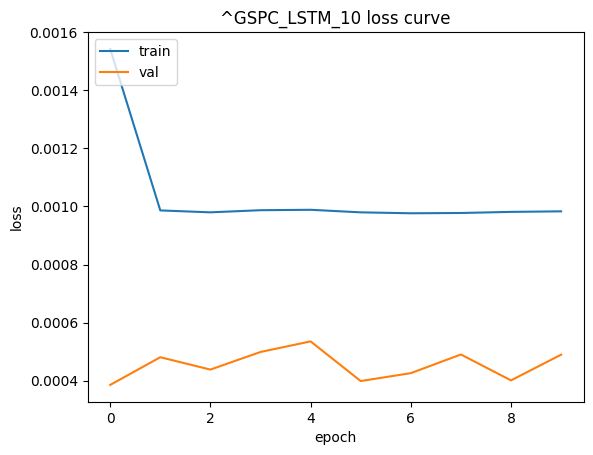


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.0012 - mae: 0.0221 - mean_absolute_percentage_error: 58.8573
Epoch 1: val_loss improved from inf to 0.00027, saving model to LSTM_50
32/32 [==============================] - 7s 154ms/step - loss: 0.0012 - mae: 0.0221 - mean_absolute_percentage_error: 58.8205 - val_loss: 2.6573e-04 - val_mae: 0.0139 - val_mean_absolute_percentage_error: 21.7941
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 9.7852e-04 - mae: 0.0181 - mean_absolute_percentage_error: 49.2519
Epoch 2: val_loss did not improve from 0.00027
32/32 [==============================] - 0s 8ms/step - loss: 9.7852e-04 - mae: 0.0181 - mean_absolute_percentage_error: 49.2519 - val_loss: 3.3038e-04 - val_mae: 0.0159 - val_mean_absolute_percentage_error: 25.0337
Epoch 3/10
26/32 [=======================>......] - ETA: 0s - loss: 0.0010 - mae: 0.0191 - mean_absolute_percentage_error: 53.0619
Epoch 3: val_loss did not improve from 0.00027
32/32 [==

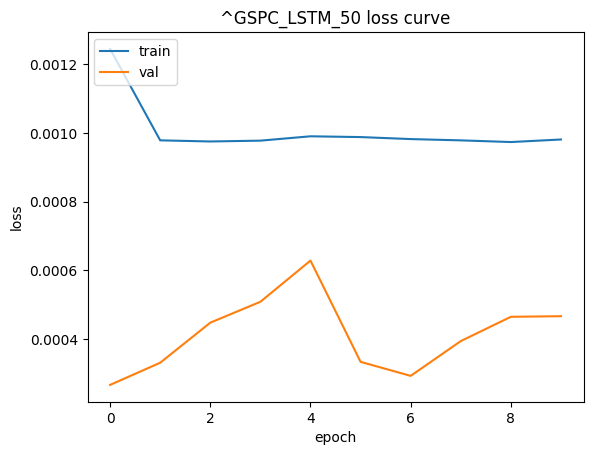


7/7 [==============================] - 1s 5ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
26/32 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0231 - mean_absolute_percentage_error: 63.9182
Epoch 1: val_loss improved from inf to 0.00054, saving model to LSTM_100
32/32 [==============================] - 7s 133ms/step - loss: 0.0012 - mae: 0.0225 - mean_absolute_percentage_error: 62.6138 - val_loss: 5.3777e-04 - val_mae: 0.0214 - val_mean_absolute_percentage_error: 34.3847
Epoch 2/10
26/32 [=======================>......] - ETA: 0s - loss: 0.0010 - mae: 0.0184 - mean_absolute_percentage_error: 49.5957    
Epoch 2: val_loss improved from 0.00054 to 0.00041, saving model to LSTM_100
32/32 [==============================] - 4s 114ms/step - loss: 9.8149e-04 - mae: 0.0183 - mean_absolute_percentage_error: 50.2676 - val_loss: 4.0827e-04 - val_mae: 0.0181 - val_mean_absolute_percentage_error: 28.7558
Epoch 3/10
28/32 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0186 - mean_absolute_percentage_error: 51.0608
Epoch 3: val_loss did n

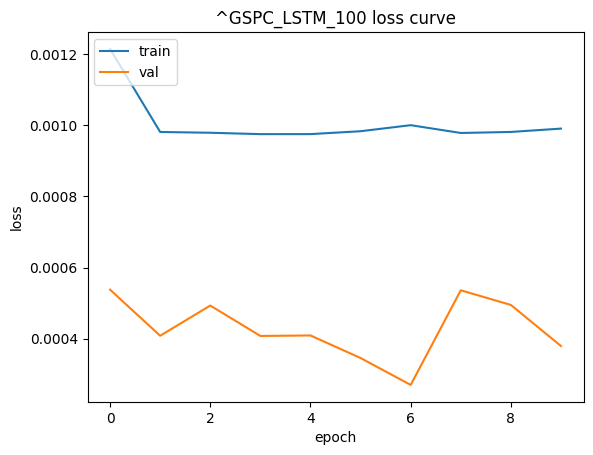


7/7 [==============================] - 1s 5ms/step
INDEX: ^DJI
----------------------


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - mae: 0.0421 - mean_absolute_percentage_error: 99.5234  
Epoch 1: val_loss improved from inf to 0.00013, saving model to RNN_10
32/32 [==============================] - 4s 62ms/step - loss: 0.0027 - mae: 0.0350 - mean_absolute_percentage_error: 89.6567 - val_loss: 1.2714e-04 - val_mae: 0.0094 - val_mean_absolute_percentage_error: 19.6340
Epoch 2/10
31/32 [============================>.] - ETA: 0s - loss: 0.0015 - mae: 0.0256 - mean_absolute_percentage_error: 72.1588
Epoch 2: val_loss did not improve from 0.00013
32/32 [==============================] - 0s 5ms/step - loss: 0.0015 - mae: 0.0257 - mean_absolute_percentage_error: 72.2520 - val_loss: 2.1323e-04 - val_mae: 0.0116 - val_mean_absolute_percentage_error: 21.8911
Epoch 3/10
18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - mae: 0.0246 - mean_absolute_percentage_error: 67.1784
Epoch 3: val_loss did not improve from 0.00013
32/32 [==========

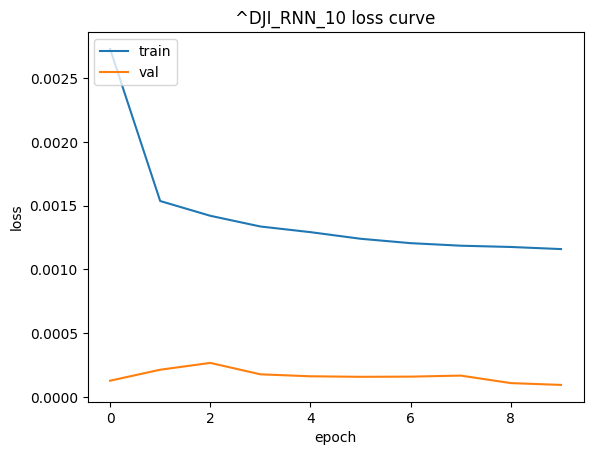


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0236 - mean_absolute_percentage_error: 60.2424
Epoch 1: val_loss improved from inf to 0.00007, saving model to RNN_50
32/32 [==============================] - 5s 93ms/step - loss: 0.0014 - mae: 0.0232 - mean_absolute_percentage_error: 59.4899 - val_loss: 6.5088e-05 - val_mae: 0.0066 - val_mean_absolute_percentage_error: 13.7674
Epoch 2/10
21/32 [==================>...........] - ETA: 0s - loss: 0.0011 - mae: 0.0193 - mean_absolute_percentage_error: 49.8245    
Epoch 2: val_loss did not improve from 0.00007
32/32 [==============================] - 0s 8ms/step - loss: 0.0011 - mae: 0.0199 - mean_absolute_percentage_error: 51.3680 - val_loss: 1.0205e-04 - val_mae: 0.0084 - val_mean_absolute_percentage_error: 16.2999
Epoch 3/10
25/32 [======================>.......] - ETA: 0s - loss: 0.0012 - mae: 0.0204 - mean_absolute_percentage_error: 51.4325    
Epoch 3: val_loss did not improve from 0.00007
32/32 [====

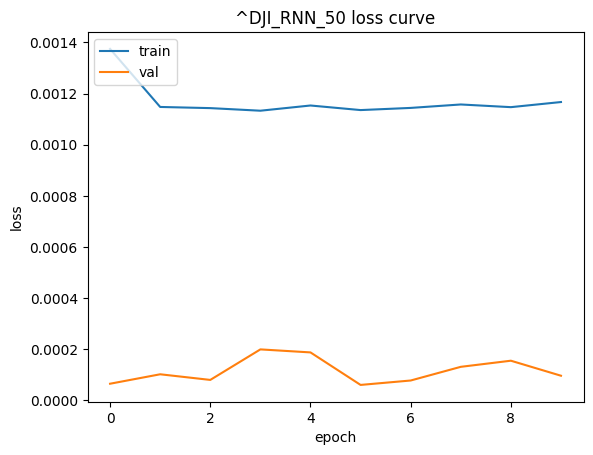


7/7 [==============================] - 0s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
31/32 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0230 - mean_absolute_percentage_error: 60.5823
Epoch 1: val_loss improved from inf to 0.00016, saving model to RNN_100
32/32 [==============================] - 3s 62ms/step - loss: 0.0013 - mae: 0.0229 - mean_absolute_percentage_error: 60.1663 - val_loss: 1.6197e-04 - val_mae: 0.0108 - val_mean_absolute_percentage_error: 20.5039
Epoch 2/10
30/32 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0196 - mean_absolute_percentage_error: 49.8877
Epoch 2: val_loss improved from 0.00016 to 0.00008, saving model to RNN_100
32/32 [==============================] - 2s 52ms/step - loss: 0.0012 - mae: 0.0195 - mean_absolute_percentage_error: 49.3754 - val_loss: 7.7060e-05 - val_mae: 0.0073 - val_mean_absolute_percentage_error: 14.4683
Epoch 3/10
31/32 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0195 - mean_absolute_percentage_error: 49.5988
Epoch 3: val_loss improved from 0.0

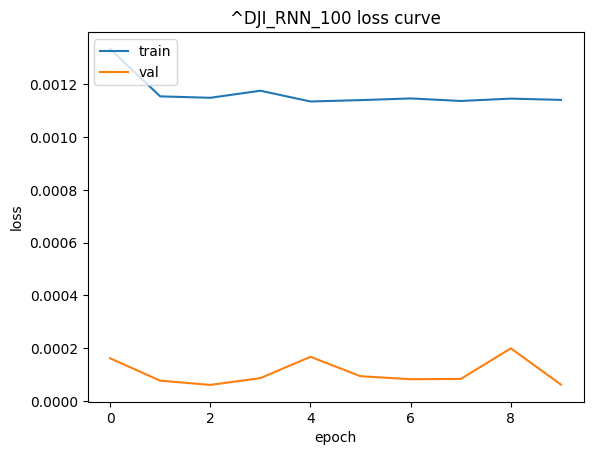


7/7 [==============================] - 0s 6ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - mae: 0.0239 - mean_absolute_percentage_error: 49.1766
Epoch 1: val_loss improved from inf to 0.00006, saving model to LSTM_10
32/32 [==============================] - 7s 137ms/step - loss: 0.0015 - mae: 0.0231 - mean_absolute_percentage_error: 50.3758 - val_loss: 6.1174e-05 - val_mae: 0.0065 - val_mean_absolute_percentage_error: 13.4058
Epoch 2/10
22/32 [===================>..........] - ETA: 0s - loss: 0.0012 - mae: 0.0209 - mean_absolute_percentage_error: 56.7655
Epoch 2: val_loss did not improve from 0.00006
32/32 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0204 - mean_absolute_percentage_error: 54.3233 - val_loss: 1.0006e-04 - val_mae: 0.0084 - val_mean_absolute_percentage_error: 16.2103
Epoch 3/10
24/32 [=====================>........] - ETA: 0s - loss: 0.0011 - mae: 0.0193 - mean_absolute_percentage_error: 48.8046
Epoch 3: val_loss did not improve from 0.00006
32/32 [==========

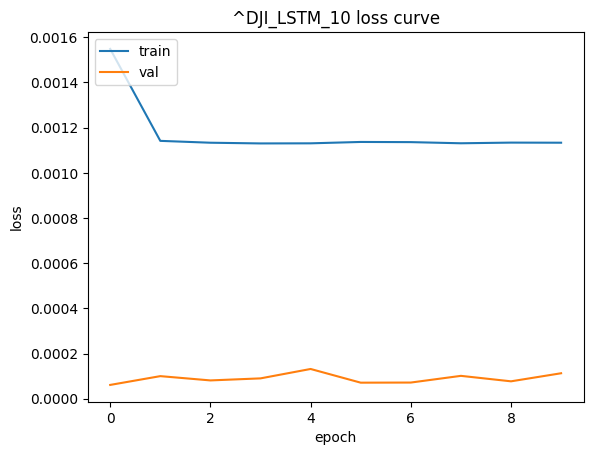


7/7 [==============================] - 1s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - mae: 0.0241 - mean_absolute_percentage_error: 56.5547
Epoch 1: val_loss improved from inf to 0.00007, saving model to LSTM_50
32/32 [==============================] - 8s 137ms/step - loss: 0.0015 - mae: 0.0237 - mean_absolute_percentage_error: 58.2645 - val_loss: 7.3988e-05 - val_mae: 0.0071 - val_mean_absolute_percentage_error: 14.2627
Epoch 2/10
26/32 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0197 - mean_absolute_percentage_error: 49.0191
Epoch 2: val_loss did not improve from 0.00007
32/32 [==============================] - 0s 6ms/step - loss: 0.0011 - mae: 0.0195 - mean_absolute_percentage_error: 49.3442 - val_loss: 8.9593e-05 - val_mae: 0.0079 - val_mean_absolute_percentage_error: 15.4731
Epoch 3/10
22/32 [===================>..........] - ETA: 0s - loss: 0.0012 - mae: 0.0193 - mean_absolute_percentage_error: 47.8205
Epoch 3: val_loss did not improve from 0.00007
32/32 [==========

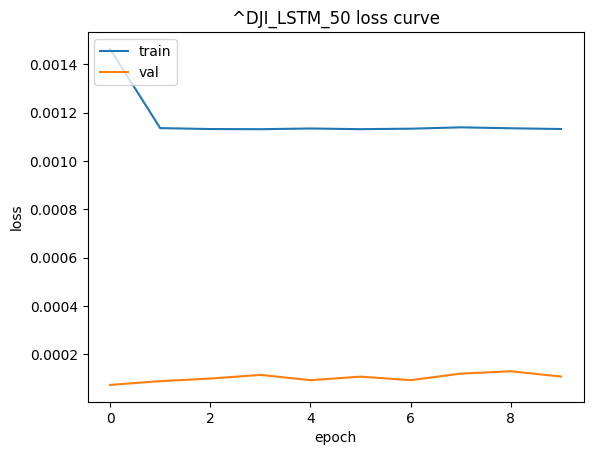


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - mae: 0.0248 - mean_absolute_percentage_error: 62.2386
Epoch 1: val_loss improved from inf to 0.00017, saving model to LSTM_100
32/32 [==============================] - 8s 173ms/step - loss: 0.0014 - mae: 0.0236 - mean_absolute_percentage_error: 60.8546 - val_loss: 1.6548e-04 - val_mae: 0.0109 - val_mean_absolute_percentage_error: 20.7894
Epoch 2/10
22/32 [===================>..........] - ETA: 0s - loss: 0.0012 - mae: 0.0193 - mean_absolute_percentage_error: 46.7539
Epoch 2: val_loss improved from 0.00017 to 0.00011, saving model to LSTM_100
32/32 [==============================] - 4s 117ms/step - loss: 0.0011 - mae: 0.0194 - mean_absolute_percentage_error: 48.1376 - val_loss: 1.0520e-04 - val_mae: 0.0086 - val_mean_absolute_percentage_error: 16.5547
Epoch 3/10
21/32 [==================>...........] - ETA: 0s - loss: 0.0013 - mae: 0.0206 - mean_absolute_percentage_error: 51.7573
Epoch 3: val_loss did not impro

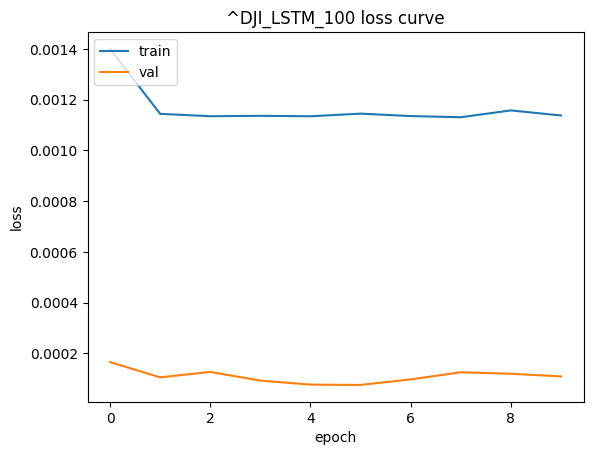


7/7 [==============================] - 0s 4ms/step
INDEX: ^N100
----------------------


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
31/33 [===========================>..] - ETA: 0s - loss: 6.8119e-04 - mae: 0.0172 - mean_absolute_percentage_error: 45.6657
Epoch 1: val_loss improved from inf to 0.00029, saving model to RNN_10
33/33 [==============================] - 3s 59ms/step - loss: 6.8824e-04 - mae: 0.0171 - mean_absolute_percentage_error: 45.2582 - val_loss: 2.9101e-04 - val_mae: 0.0131 - val_mean_absolute_percentage_error: 23.0197
Epoch 2/10
32/33 [============================>.] - ETA: 0s - loss: 5.8387e-04 - mae: 0.0141 - mean_absolute_percentage_error: 35.9279
Epoch 2: val_loss improved from 0.00029 to 0.00020, saving model to RNN_10
33/33 [==============================] - 2s 64ms/step - loss: 5.8219e-04 - mae: 0.0141 - mean_absolute_percentage_error: 35.9554 - val_loss: 1.9544e-04 - val_mae: 0.0107 - val_mean_absolute_percentage_error: 20.4660
Epoch 3/10
24/33 [====================>.........] - ETA: 0s - loss: 4.8268e-04 - mae: 0.0136 - mean_absolute_percentage_error: 37.7829
Epoch 3: val_loss

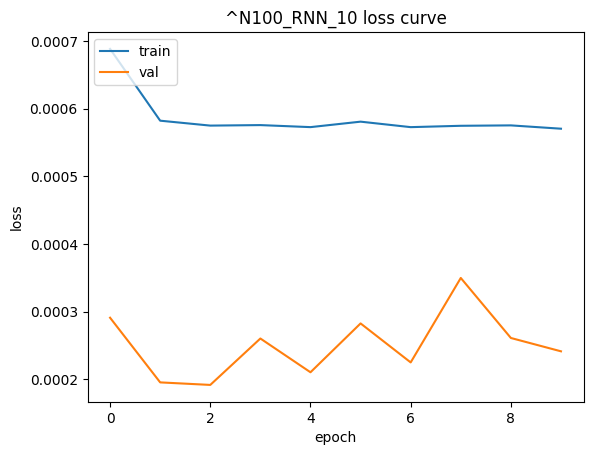


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
27/33 [=======================>......] - ETA: 0s - loss: 7.7283e-04 - mae: 0.0190 - mean_absolute_percentage_error: 50.8330
Epoch 1: val_loss improved from inf to 0.00019, saving model to RNN_50
33/33 [==============================] - 4s 61ms/step - loss: 7.5977e-04 - mae: 0.0185 - mean_absolute_percentage_error: 48.9390 - val_loss: 1.8666e-04 - val_mae: 0.0106 - val_mean_absolute_percentage_error: 22.7322
Epoch 2/10
28/33 [========================>.....] - ETA: 0s - loss: 6.0605e-04 - mae: 0.0157 - mean_absolute_percentage_error: 42.6541
Epoch 2: val_loss did not improve from 0.00019
33/33 [==============================] - 0s 6ms/step - loss: 5.9546e-04 - mae: 0.0154 - mean_absolute_percentage_error: 41.9403 - val_loss: 3.7333e-04 - val_mae: 0.0150 - val_mean_absolute_percentage_error: 26.5163
Epoch 3/10
24/33 [====================>.........] - ETA: 0s - loss: 5.4279e-04 - mae: 0.0136 - mean_absolute_percentage_error: 35.5418
Epoch 3: val_loss did not improve from 0.00019

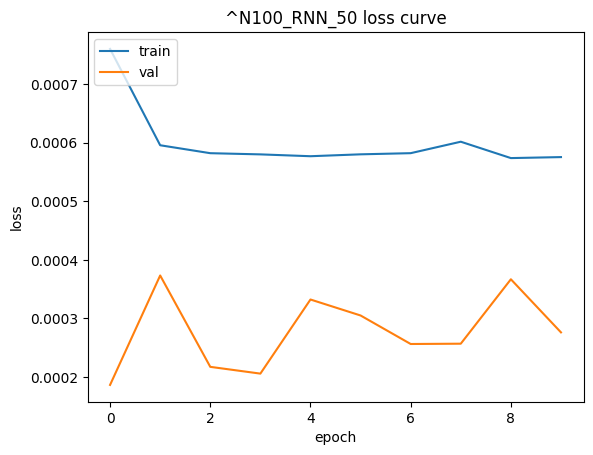


7/7 [==============================] - 0s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
23/33 [===================>..........] - ETA: 0s - loss: 8.4035e-04 - mae: 0.0195 - mean_absolute_percentage_error: 51.7718
Epoch 1: val_loss improved from inf to 0.00032, saving model to RNN_100
33/33 [==============================] - 4s 88ms/step - loss: 7.4248e-04 - mae: 0.0181 - mean_absolute_percentage_error: 49.1957 - val_loss: 3.2050e-04 - val_mae: 0.0139 - val_mean_absolute_percentage_error: 24.6946
Epoch 2/10
31/33 [===========================>..] - ETA: 0s - loss: 5.9751e-04 - mae: 0.0143 - mean_absolute_percentage_error: 36.6579
Epoch 2: val_loss improved from 0.00032 to 0.00026, saving model to RNN_100
33/33 [==============================] - 2s 68ms/step - loss: 5.8744e-04 - mae: 0.0143 - mean_absolute_percentage_error: 36.7465 - val_loss: 2.5659e-04 - val_mae: 0.0124 - val_mean_absolute_percentage_error: 22.9128
Epoch 3/10
32/33 [============================>.] - ETA: 0s - loss: 5.7419e-04 - mae: 0.0142 - mean_absolute_percentage_error: 36.8531
Epoch 3: val_lo

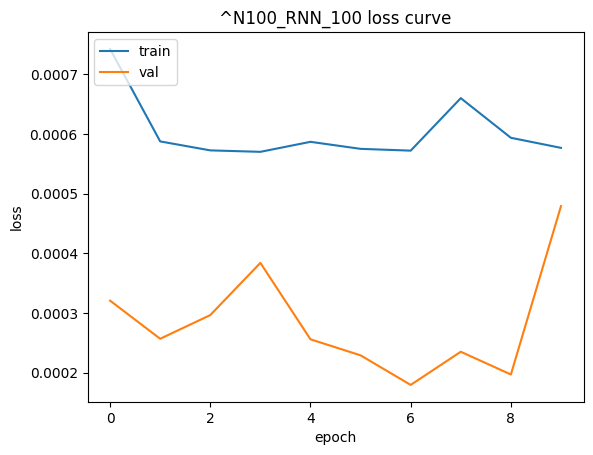


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
31/33 [===========================>..] - ETA: 0s - loss: 7.8809e-04 - mae: 0.0188 - mean_absolute_percentage_error: 47.6797
Epoch 1: val_loss improved from inf to 0.00017, saving model to LSTM_10
33/33 [==============================] - 7s 160ms/step - loss: 7.9498e-04 - mae: 0.0188 - mean_absolute_percentage_error: 47.6168 - val_loss: 1.6945e-04 - val_mae: 0.0100 - val_mean_absolute_percentage_error: 20.2938
Epoch 2/10
27/33 [=======================>......] - ETA: 0s - loss: 6.1057e-04 - mae: 0.0148 - mean_absolute_percentage_error: 38.8090
Epoch 2: val_loss did not improve from 0.00017
33/33 [==============================] - 0s 6ms/step - loss: 5.8228e-04 - mae: 0.0146 - mean_absolute_percentage_error: 38.4854 - val_loss: 2.5206e-04 - val_mae: 0.0122 - val_mean_absolute_percentage_error: 21.9521
Epoch 3/10
23/33 [===================>..........] - ETA: 0s - loss: 5.5584e-04 - mae: 0.0139 - mean_absolute_percentage_error: 35.4849
Epoch 3: val_loss did not improve from 0.000

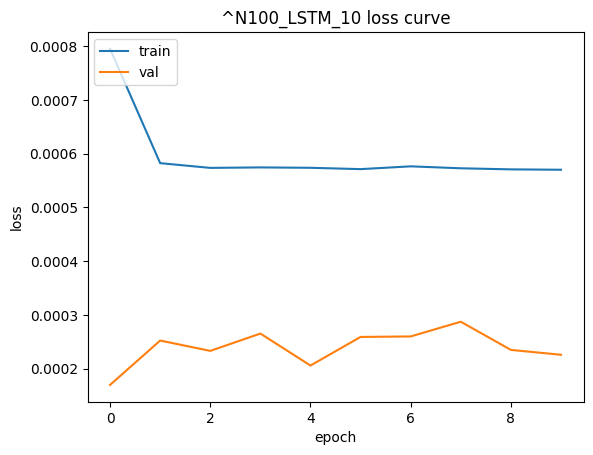


7/7 [==============================] - 0s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
25/33 [=====================>........] - ETA: 0s - loss: 8.3827e-04 - mae: 0.0202 - mean_absolute_percentage_error: 52.9905
Epoch 1: val_loss improved from inf to 0.00027, saving model to LSTM_50
33/33 [==============================] - 7s 141ms/step - loss: 7.5925e-04 - mae: 0.0192 - mean_absolute_percentage_error: 51.8889 - val_loss: 2.6536e-04 - val_mae: 0.0126 - val_mean_absolute_percentage_error: 22.7341
Epoch 2/10
27/33 [=======================>......] - ETA: 0s - loss: 5.9584e-04 - mae: 0.0139 - mean_absolute_percentage_error: 34.7942
Epoch 2: val_loss improved from 0.00027 to 0.00025, saving model to LSTM_50
33/33 [==============================] - 5s 149ms/step - loss: 5.7476e-04 - mae: 0.0139 - mean_absolute_percentage_error: 35.0286 - val_loss: 2.4581e-04 - val_mae: 0.0121 - val_mean_absolute_percentage_error: 22.2520
Epoch 3/10
22/33 [===================>..........] - ETA: 0s - loss: 5.7531e-04 - mae: 0.0141 - mean_absolute_percentage_error: 36.2107
Epoch 3: val_

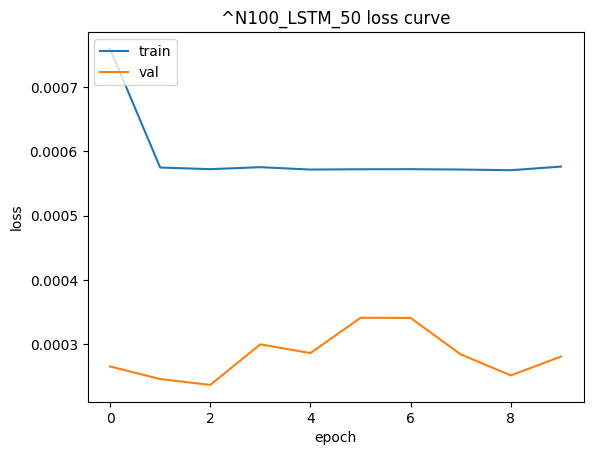


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
28/33 [========================>.....] - ETA: 0s - loss: 8.3520e-04 - mae: 0.0199 - mean_absolute_percentage_error: 53.2125
Epoch 1: val_loss improved from inf to 0.00041, saving model to LSTM_100
33/33 [==============================] - 9s 173ms/step - loss: 7.6756e-04 - mae: 0.0188 - mean_absolute_percentage_error: 50.4458 - val_loss: 4.1147e-04 - val_mae: 0.0159 - val_mean_absolute_percentage_error: 27.9321
Epoch 2/10
26/33 [======================>.......] - ETA: 0s - loss: 5.7707e-04 - mae: 0.0140 - mean_absolute_percentage_error: 35.3599
Epoch 2: val_loss improved from 0.00041 to 0.00028, saving model to LSTM_100
33/33 [==============================] - 3s 107ms/step - loss: 5.7927e-04 - mae: 0.0142 - mean_absolute_percentage_error: 36.0090 - val_loss: 2.7517e-04 - val_mae: 0.0129 - val_mean_absolute_percentage_error: 23.4323
Epoch 3/10
25/33 [=====================>........] - ETA: 0s - loss: 6.3277e-04 - mae: 0.0150 - mean_absolute_percentage_error: 38.8226
Epoch 3: va

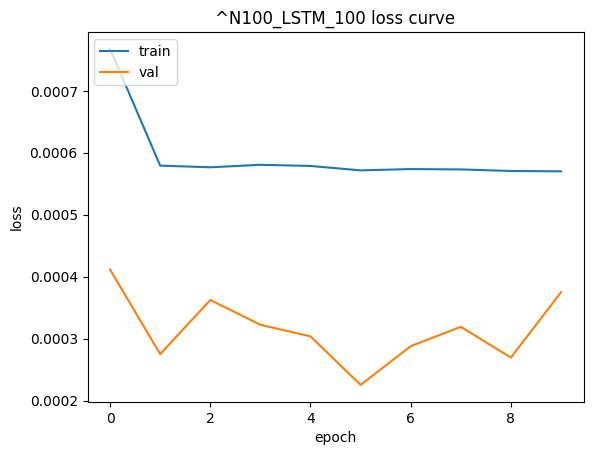


7/7 [==============================] - 0s 4ms/step
INDEX: ^N225
----------------------


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
20/31 [==================>...........] - ETA: 0s - loss: 6.5215e-04 - mae: 0.0192 - mean_absolute_percentage_error: 44.2398
Epoch 1: val_loss improved from inf to 0.00014, saving model to RNN_10
31/31 [==============================] - 3s 59ms/step - loss: 5.3001e-04 - mae: 0.0170 - mean_absolute_percentage_error: 40.5347 - val_loss: 1.4209e-04 - val_mae: 0.0098 - val_mean_absolute_percentage_error: 18.3163
Epoch 2/10
15/31 [=============>................] - ETA: 0s - loss: 4.0739e-04 - mae: 0.0126 - mean_absolute_percentage_error: 26.5690
Epoch 2: val_loss improved from 0.00014 to 0.00008, saving model to RNN_10
31/31 [==============================] - 2s 50ms/step - loss: 3.4287e-04 - mae: 0.0123 - mean_absolute_percentage_error: 28.1594 - val_loss: 8.3514e-05 - val_mae: 0.0073 - val_mean_absolute_percentage_error: 14.1128
Epoch 3/10
17/31 [===============>..............] - ETA: 0s - loss: 3.2079e-04 - mae: 0.0119 - mean_absolute_percentage_error: 26.7977
Epoch 3: val_loss

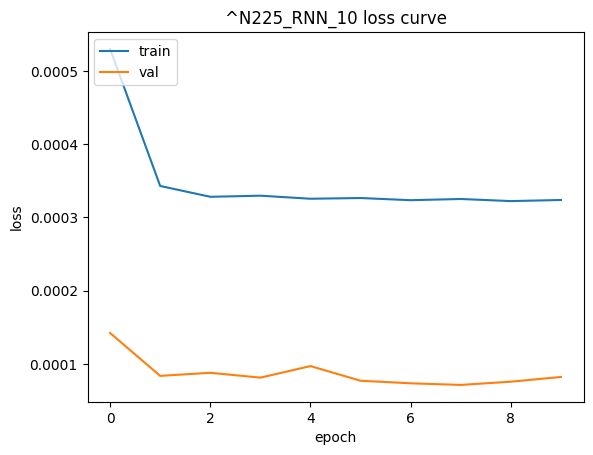


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
19/31 [=================>............] - ETA: 0s - loss: 6.8629e-04 - mae: 0.0198 - mean_absolute_percentage_error: 47.5543
Epoch 1: val_loss improved from inf to 0.00007, saving model to RNN_50
31/31 [==============================] - 3s 60ms/step - loss: 5.5082e-04 - mae: 0.0168 - mean_absolute_percentage_error: 39.1818 - val_loss: 7.2465e-05 - val_mae: 0.0068 - val_mean_absolute_percentage_error: 13.6120
Epoch 2/10
16/31 [==============>...............] - ETA: 0s - loss: 3.3272e-04 - mae: 0.0126 - mean_absolute_percentage_error: 29.5188
Epoch 2: val_loss did not improve from 0.00007
31/31 [==============================] - 0s 5ms/step - loss: 3.2532e-04 - mae: 0.0124 - mean_absolute_percentage_error: 29.2602 - val_loss: 8.3733e-05 - val_mae: 0.0074 - val_mean_absolute_percentage_error: 14.4403
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 3.2393e-04 - mae: 0.0122 - mean_absolute_percentage_error: 28.2926
Epoch 3: val_loss did not improve from 0.00007

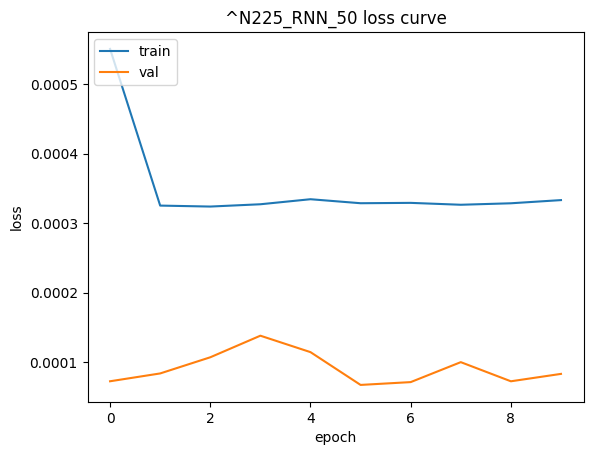


7/7 [==============================] - 0s 3ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
28/31 [==========================>...] - ETA: 0s - loss: 5.3523e-04 - mae: 0.0166 - mean_absolute_percentage_error: 38.8789
Epoch 1: val_loss improved from inf to 0.00014, saving model to RNN_100
31/31 [==============================] - 4s 80ms/step - loss: 5.0477e-04 - mae: 0.0160 - mean_absolute_percentage_error: 37.7546 - val_loss: 1.4158e-04 - val_mae: 0.0098 - val_mean_absolute_percentage_error: 18.4411
Epoch 2/10
29/31 [===========================>..] - ETA: 0s - loss: 3.4730e-04 - mae: 0.0127 - mean_absolute_percentage_error: 29.2548
Epoch 2: val_loss improved from 0.00014 to 0.00007, saving model to RNN_100
31/31 [==============================] - 2s 53ms/step - loss: 3.4591e-04 - mae: 0.0126 - mean_absolute_percentage_error: 29.1205 - val_loss: 6.5162e-05 - val_mae: 0.0064 - val_mean_absolute_percentage_error: 12.8730
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 3.2557e-04 - mae: 0.0123 - mean_absolute_percentage_error: 28.6145
Epoch 3: val_lo

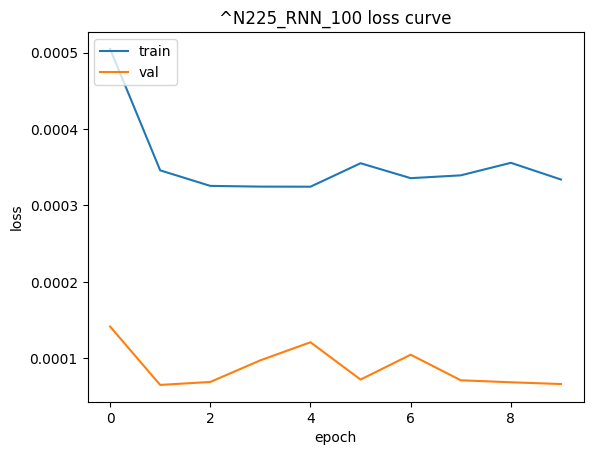


7/7 [==============================] - 0s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
26/31 [========================>.....] - ETA: 0s - loss: 9.5662e-04 - mae: 0.0237 - mean_absolute_percentage_error: 49.6027
Epoch 1: val_loss improved from inf to 0.00007, saving model to LSTM_10
31/31 [==============================] - 8s 200ms/step - loss: 8.5878e-04 - mae: 0.0220 - mean_absolute_percentage_error: 46.7746 - val_loss: 6.9399e-05 - val_mae: 0.0066 - val_mean_absolute_percentage_error: 13.6170
Epoch 2/10
28/31 [==========================>...] - ETA: 0s - loss: 3.2952e-04 - mae: 0.0130 - mean_absolute_percentage_error: 32.2694
Epoch 2: val_loss did not improve from 0.00007
31/31 [==============================] - 0s 9ms/step - loss: 3.3189e-04 - mae: 0.0130 - mean_absolute_percentage_error: 31.9965 - val_loss: 8.9559e-05 - val_mae: 0.0076 - val_mean_absolute_percentage_error: 14.8428
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 3.2133e-04 - mae: 0.0122 - mean_absolute_percentage_error: 28.3699
Epoch 3: val_loss did not improve from 0.000

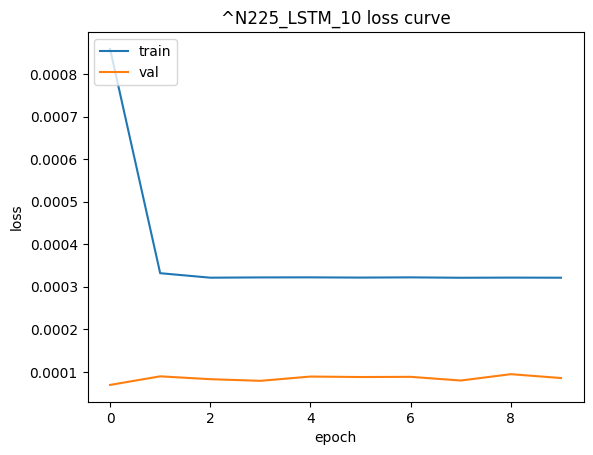


7/7 [==============================] - 1s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
24/31 [======================>.......] - ETA: 0s - loss: 7.6347e-04 - mae: 0.0205 - mean_absolute_percentage_error: 45.5857
Epoch 1: val_loss improved from inf to 0.00007, saving model to LSTM_50
31/31 [==============================] - 7s 138ms/step - loss: 6.6667e-04 - mae: 0.0191 - mean_absolute_percentage_error: 43.9655 - val_loss: 6.5444e-05 - val_mae: 0.0065 - val_mean_absolute_percentage_error: 14.1855
Epoch 2/10
23/31 [=====================>........] - ETA: 0s - loss: 3.2801e-04 - mae: 0.0122 - mean_absolute_percentage_error: 28.0430
Epoch 2: val_loss did not improve from 0.00007
31/31 [==============================] - 0s 7ms/step - loss: 3.2675e-04 - mae: 0.0122 - mean_absolute_percentage_error: 28.0079 - val_loss: 7.6802e-05 - val_mae: 0.0070 - val_mean_absolute_percentage_error: 13.9078
Epoch 3/10
30/31 [============================>.] - ETA: 0s - loss: 3.2177e-04 - mae: 0.0122 - mean_absolute_percentage_error: 28.4282
Epoch 3: val_loss did not improve from 0.000

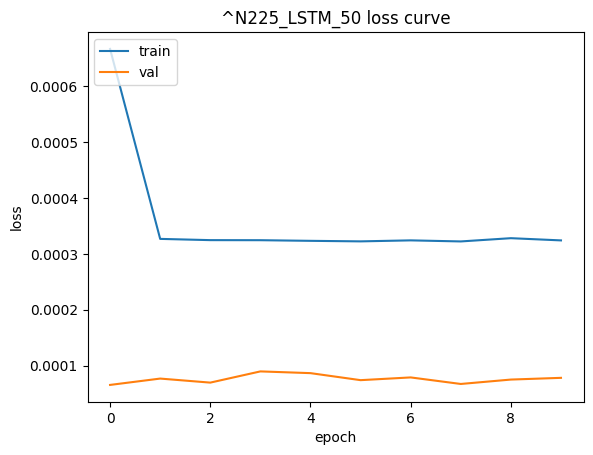


7/7 [==============================] - 0s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


Epoch 1/10
24/31 [======================>.......] - ETA: 0s - loss: 7.5451e-04 - mae: 0.0212 - mean_absolute_percentage_error: 49.8201
Epoch 1: val_loss improved from inf to 0.00013, saving model to LSTM_100
31/31 [==============================] - 6s 136ms/step - loss: 6.5562e-04 - mae: 0.0193 - mean_absolute_percentage_error: 46.3528 - val_loss: 1.3015e-04 - val_mae: 0.0092 - val_mean_absolute_percentage_error: 17.3754
Epoch 2/10
29/31 [===========================>..] - ETA: 0s - loss: 3.3916e-04 - mae: 0.0121 - mean_absolute_percentage_error: 26.8624
Epoch 2: val_loss improved from 0.00013 to 0.00007, saving model to LSTM_100
31/31 [==============================] - 5s 152ms/step - loss: 3.3433e-04 - mae: 0.0120 - mean_absolute_percentage_error: 26.8757 - val_loss: 6.9899e-05 - val_mae: 0.0066 - val_mean_absolute_percentage_error: 13.6017
Epoch 3/10
26/31 [========================>.....] - ETA: 0s - loss: 3.3310e-04 - mae: 0.0124 - mean_absolute_percentage_error: 28.6369
Epoch 3: va

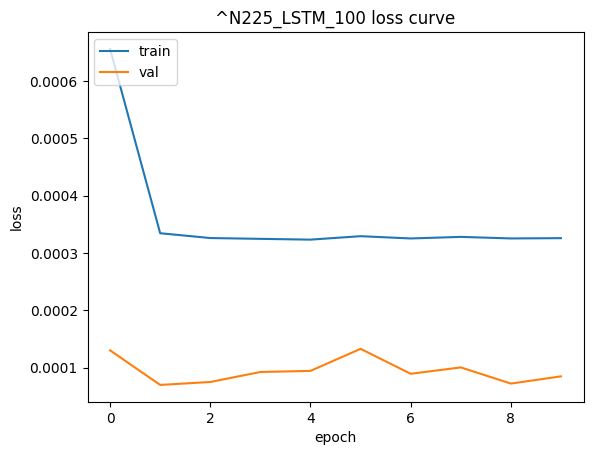


7/7 [==============================] - 0s 4ms/step


<ipython-input-110-4fab77926fc4>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DL = DL.append(t,ignore_index=True)


<Figure size 640x480 with 0 Axes>

In [110]:
DL = pd.DataFrame()

for stock in tickers:
  print('INDEX:',stock)
  print('----------------------')
  df = load_to_df(stock)
  get_price_returns(df)
  get_historical_volatility(df)


  X,y = create_sequences(df)
  X_train, y_train, X_val, y_val, X_test, y_test = dl_tts(X,y)

  for i in product(models,units):
    t = {'Index':stock}
    keras.backend.clear_session()
    model_name = str(i[0]) + '_' + str(i[1])
    model = model_gen(i[0],i[1])
    t['Model'] = model_name
    # early stopping
    EarlyS = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    ModelC = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32,  validation_data=(X_val, y_val), callbacks=[EarlyS, ModelC])

    plt.clf()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(stock+'_'+model_name+ ' loss curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig(f"/content/drive/MyDrive/Uni of Adelaide/CS7318/Assignment 3/{stock+'_'+model_name}.png")
    print()

    # pickle history
    pickle.dump(history, open(f"/content/drive/MyDrive/Uni of Adelaide/CS7318/Assignment 3/{stock+'_'+model_name}_history.pkl", 'wb'))

    # evaluation of metrics
    predicted_residual = model.predict(X_test)
    predicted_residual = [x[0] for x in predicted_residual]
    mape = mean_absolute_percentage_error(y_test, predicted_residual)
    mse = mean_squared_error(y_test, predicted_residual)
    t['mape'] = mape
    t['mse'] = mse
    DL = DL.append(t,ignore_index=True)

DL.to_csv(r'/content/drive/MyDrive/Uni of Adelaide/CS7318/Assignment 3/DL_results.csv')

In [114]:
predicted_residual
predicted_residual = [x[0] for x in predicted_residual]

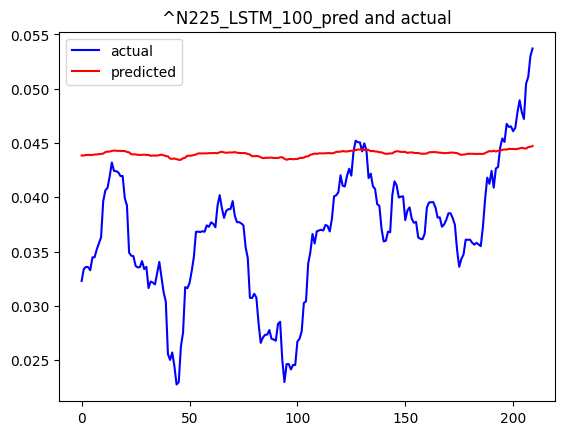

In [118]:
plt.plot(y_test,c='b',label='actual')
# plt.plot(df_train.index,df_train["close"],c='b')
# plt.plot(df_val.index,df_val["close"],c='b')
plt.title('^N225_LSTM_100_pred and actual')
plt.plot(predicted_residual,color='r',label='predicted')
plt.legend()